# <center> PREDICTING THE NEXT DAY PRICE OF BITCOIN USING MACHINE LEARNING TECHNIQUES </center>
## <center> Feature Scaling & Feature selection </center>
### <center>2148040, 2148041 </center>

Feature selection is a process of choosing the important and relevant input variables for the next process - modelling in the study.This helps in saving memory, computational time and gets rid of noise or irrelevant data.

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing to handle highly varying magnitudes or values or units.

## Import data & libraries

In [1]:
#library for data analysis, manipulation 
import pandas as pd
import numpy as np

#Visuals
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import missingno as msno

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#For Random Forest model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [2]:
final_df = pd.read_csv('final_data_after_feat_engg.csv',index_col=0).reset_index(drop=True)
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,macd top100_to_total_percentage,macd hist avg_fee_to_reward,macd signal avg_fee_to_reward,macd avg_fee_to_reward,macd hist number_of_coins_in_circulation,macd signal number_of_coins_in_circulation,macd number_of_coins_in_circulation,macd hist miner_revenue,macd signal miner_revenue,macd miner_revenue
0,2013-04-01,93.0,106.0,92.2,104.0,52572,139256,48809,6695826,6.550211e+13,...,0.134009,0.001051,-0.024929,-0.023878,-113.273476,30476.415612,30363.142136,14998.899375,5.568929e+04,7.068819e+04
1,2013-04-02,104.0,118.4,99.0,118.0,63095,175443,62276,6695826,6.184560e+13,...,0.149929,0.011957,-0.021940,-0.009982,126.563476,30508.056481,30634.619957,16891.203618,5.991209e+04,7.680330e+04
2,2013-04-03,118.0,147.0,110.0,135.0,63766,184209,69174,6695826,6.027037e+13,...,0.157742,0.034832,-0.013232,0.021600,-106.799542,30481.356595,30374.557054,17100.252403,6.418716e+04,8.128741e+04
3,2013-04-04,135.0,142.1,116.4,132.1,66738,221568,71753,6695826,5.527246e+13,...,0.162305,0.069927,0.004250,0.074177,58.570562,30495.999236,30554.569798,14903.051588,6.791292e+04,8.281597e+04
4,2013-04-05,132.1,144.9,130.2,142.3,61215,190067,69310,7005058,5.181545e+13,...,0.151506,0.055290,0.018073,0.073363,149.158958,30533.288975,30682.447934,17313.693182,7.224134e+04,8.955503e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2022-03-27,44542.0,46947.0,44445.0,46859.0,218071,595651,421737,27452707696467,1.994591e+20,...,-0.010968,-0.000720,-0.064273,-0.064993,39.452212,6394.097925,6433.550137,280959.444736,8.125682e+05,1.093528e+06
3283,2022-03-28,46859.0,48199.0,46672.0,47105.0,293145,683575,520476,27452707696467,1.925705e+20,...,-0.008809,0.005104,-0.062998,-0.057894,38.226623,6403.654581,6441.881204,637429.007106,9.719254e+05,1.609354e+06
3284,2022-03-29,47126.0,48127.0,47029.0,47449.0,286789,656320,519299,27452707696467,2.206193e+20,...,-0.012362,0.007018,-0.061243,-0.054224,32.914105,6411.883107,6444.797212,677398.482495,1.141275e+06,1.818674e+06
3285,2022-03-30,47449.0,47714.0,46601.0,47075.0,272729,727827,485753,27452707696467,1.975128e+20,...,-0.014846,0.025193,-0.054945,-0.029752,35.214961,6420.686847,6455.901808,340545.740699,1.226411e+06,1.566957e+06


In [3]:
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [4]:
final_df.dropna(inplace=True)

In [5]:
final_df.shape

(3287, 853)

The data set after feature engineering has the shape of 3287 rows and 853 columns. The objective is to identify the important features among these columns.

### Defining function for feature selection

Parameters of the function are - 
1. df - data frame for the study
2. feat_important - the variable whoes feature importance is to be calculated
3. n_Select_features - number of variables 

In [6]:
def feature_imp(df,feat_importance,n_select_features):
    
    #Creating a data frame to save the feature importance level
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})
    
    #sorting the feature importance level in non-increasing order
    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]

    #Creating plot for showing the feature importance 
    fig,ax = plt.subplots(figsize=(14,12))
    ax = sns.barplot(x = "Feature Importance",y = "Feature Name",data=feat_imp_df,palette="nipy_spectral")
    plt.title('Feature Importances')
    cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    minfi = min(feat_imp_df['Feature Importance'])
    maxfi = max(feat_imp_df['Feature Importance'])
    norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    ax.xaxis.grid()
    plt.show()
    return feat_imp_df,df[feat_imp_df['Feature Name']]

## Feature Scaling

We are scaling the data to eliminate the highly varying magnitude using RobustScaler() and MinMaxScaler(). The robust scaling is robust to the outliers as it uses the concept of Inter Quartile Range (IQR).

In [7]:
X = final_df.drop(['Date','next_day_closing_price'],axis=1)

In [8]:
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])
X_scaled

,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,mining_profitability,...,macd top100_to_total_percentage,macd hist avg_fee_to_reward,macd signal avg_fee_to_reward,macd avg_fee_to_reward,macd hist number_of_coins_in_circulation,macd signal number_of_coins_in_circulation,macd number_of_coins_in_circulation,macd hist miner_revenue,macd signal miner_revenue,macd miner_revenue
0,0.000365,0.000450,0.000637,0.000528,0.048669,0.068533,0.025709,0.000000e+00,5.965062e-08,0.540741,...,0.791206,0.427493,0.451094,0.418200,0.633362,0.848929,0.836064,0.681407,0.496733,0.497508
1,0.000528,0.000630,0.000739,0.000735,0.071531,0.107780,0.044965,0.000000e+00,4.371441e-08,0.598410,...,0.803548,0.429960,0.451452,0.419506,0.716317,0.849984,0.844986,0.681728,0.497029,0.497882
2,0.000735,0.001045,0.000905,0.000987,0.072989,0.117287,0.054828,0.000000e+00,3.684908e-08,0.662970,...,0.809604,0.435134,0.452493,0.422472,0.635601,0.849094,0.836439,0.681764,0.497328,0.498155
3,0.000987,0.000974,0.001002,0.000944,0.079446,0.157806,0.058516,0.000000e+00,1.506666e-08,0.657353,...,0.813142,0.443073,0.454583,0.427410,0.692800,0.849582,0.842355,0.681390,0.497589,0.498249
4,0.000944,0.001014,0.001210,0.001095,0.067447,0.123641,0.055022,1.092080e-08,0.000000e+00,0.745205,...,0.804770,0.439762,0.456235,0.427334,0.724133,0.850825,0.846558,0.681800,0.497892,0.498660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,0.659256,0.680136,0.669760,0.693610,0.408224,0.563525,0.558943,9.695165e-01,8.693031e-01,0.000009,...,0.678815,0.427093,0.446391,0.414339,0.686187,0.046116,0.049562,0.726641,0.549713,0.559936
3283,0.693602,0.698303,0.703358,0.697257,0.571326,0.658885,0.700126,9.695165e-01,8.392804e-01,0.000014,...,0.680489,0.428410,0.446543,0.415006,0.685763,0.046435,0.049836,0.787269,0.560868,0.591419
3284,0.697560,0.697259,0.708744,0.702356,0.557517,0.629325,0.698443,9.695165e-01,9.615256e-01,0.000011,...,0.677734,0.428843,0.446753,0.415350,0.683926,0.046709,0.049932,0.794067,0.572722,0.604195
3285,0.702348,0.691266,0.702287,0.696812,0.526971,0.706879,0.650477,9.695165e-01,8.608208e-01,0.000011,...,0.675809,0.432954,0.447506,0.417649,0.684722,0.047002,0.050297,0.736775,0.578682,0.588831


### Checking for missing values in the scaled data

In [9]:
for col in X_scaled.columns:
    if(X_scaled[col].isnull().sum()>0):
        print(col)

In [10]:
final_df.isnull().sum().sum()

0

In [11]:
final_df=final_df.dropna()

In [12]:
final_df.isnull().sum().sum()

0

In [13]:
X = final_df.drop(['Date','next_day_closing_price'],axis=1)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])
X_scaled

,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,mining_profitability,...,macd top100_to_total_percentage,macd hist avg_fee_to_reward,macd signal avg_fee_to_reward,macd avg_fee_to_reward,macd hist number_of_coins_in_circulation,macd signal number_of_coins_in_circulation,macd number_of_coins_in_circulation,macd hist miner_revenue,macd signal miner_revenue,macd miner_revenue
0,0.000365,0.000450,0.000637,0.000528,0.048669,0.068533,0.025709,0.000000e+00,5.965062e-08,0.540741,...,0.791206,0.427493,0.451094,0.418200,0.633362,0.848929,0.836064,0.681407,0.496733,0.497508
1,0.000528,0.000630,0.000739,0.000735,0.071531,0.107780,0.044965,0.000000e+00,4.371441e-08,0.598410,...,0.803548,0.429960,0.451452,0.419506,0.716317,0.849984,0.844986,0.681728,0.497029,0.497882
2,0.000735,0.001045,0.000905,0.000987,0.072989,0.117287,0.054828,0.000000e+00,3.684908e-08,0.662970,...,0.809604,0.435134,0.452493,0.422472,0.635601,0.849094,0.836439,0.681764,0.497328,0.498155
3,0.000987,0.000974,0.001002,0.000944,0.079446,0.157806,0.058516,0.000000e+00,1.506666e-08,0.657353,...,0.813142,0.443073,0.454583,0.427410,0.692800,0.849582,0.842355,0.681390,0.497589,0.498249
4,0.000944,0.001014,0.001210,0.001095,0.067447,0.123641,0.055022,1.092080e-08,0.000000e+00,0.745205,...,0.804770,0.439762,0.456235,0.427334,0.724133,0.850825,0.846558,0.681800,0.497892,0.498660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,0.659256,0.680136,0.669760,0.693610,0.408224,0.563525,0.558943,9.695165e-01,8.693031e-01,0.000009,...,0.678815,0.427093,0.446391,0.414339,0.686187,0.046116,0.049562,0.726641,0.549713,0.559936
3283,0.693602,0.698303,0.703358,0.697257,0.571326,0.658885,0.700126,9.695165e-01,8.392804e-01,0.000014,...,0.680489,0.428410,0.446543,0.415006,0.685763,0.046435,0.049836,0.787269,0.560868,0.591419
3284,0.697560,0.697259,0.708744,0.702356,0.557517,0.629325,0.698443,9.695165e-01,9.615256e-01,0.000011,...,0.677734,0.428843,0.446753,0.415350,0.683926,0.046709,0.049932,0.794067,0.572722,0.604195
3285,0.702348,0.691266,0.702287,0.696812,0.526971,0.706879,0.650477,9.695165e-01,8.608208e-01,0.000011,...,0.675809,0.432954,0.447506,0.417649,0.684722,0.047002,0.050297,0.736775,0.578682,0.588831


The data is been scaled from 0 to 1 range. This is Feature scaling

### Random Forest  for feature selection

We are using random forest technique over classification or regression technique because the forest decision method is a random extraction method and avoids correlation among all the features. This reduces the chances of overfitting, increases accuracy. When we train a tree, we select a feature which is having least impurity.

In [14]:
y = final_df['next_day_closing_price']
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=1)
rf.fit(X_scaled,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   37.4s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestRegressor(n_jobs=-1, random_state=1, verbose=5)

In [15]:
feat_range = list(range(10,60,5))

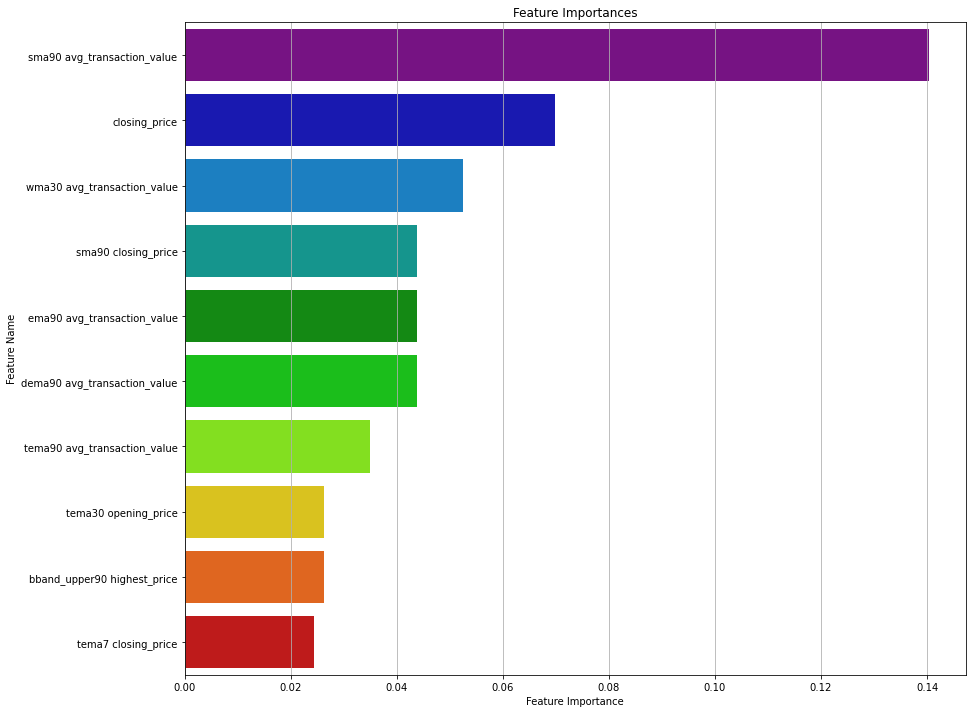

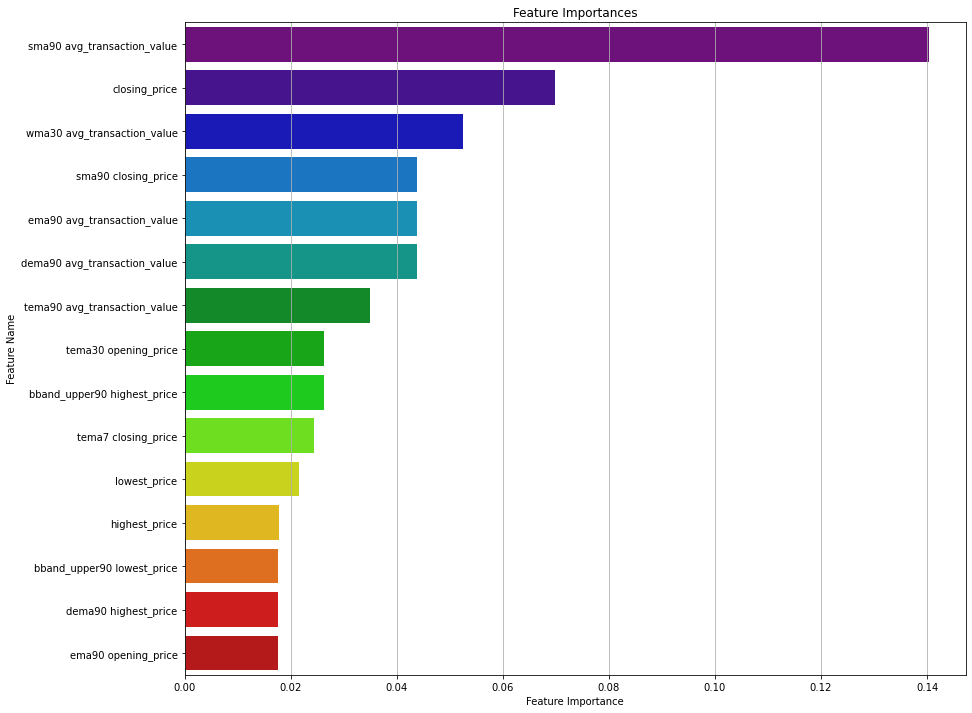

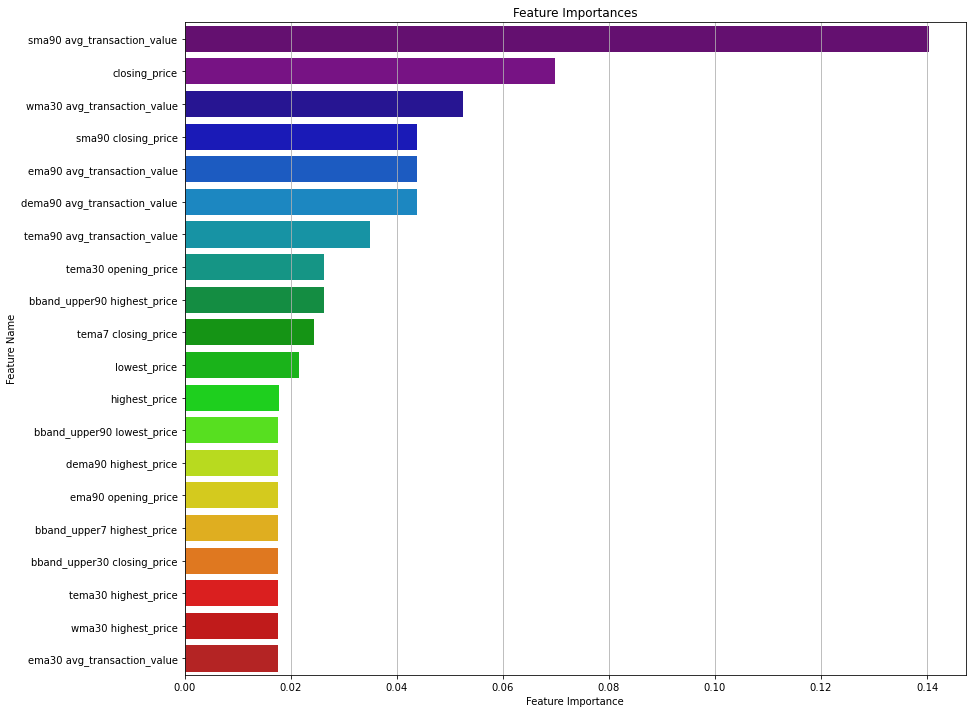

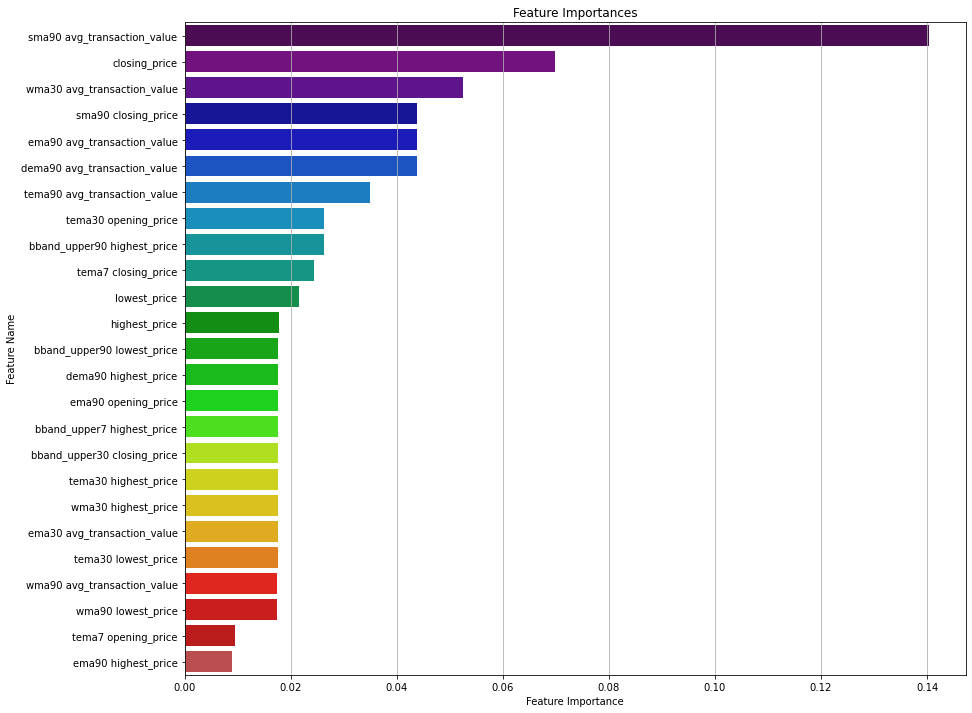

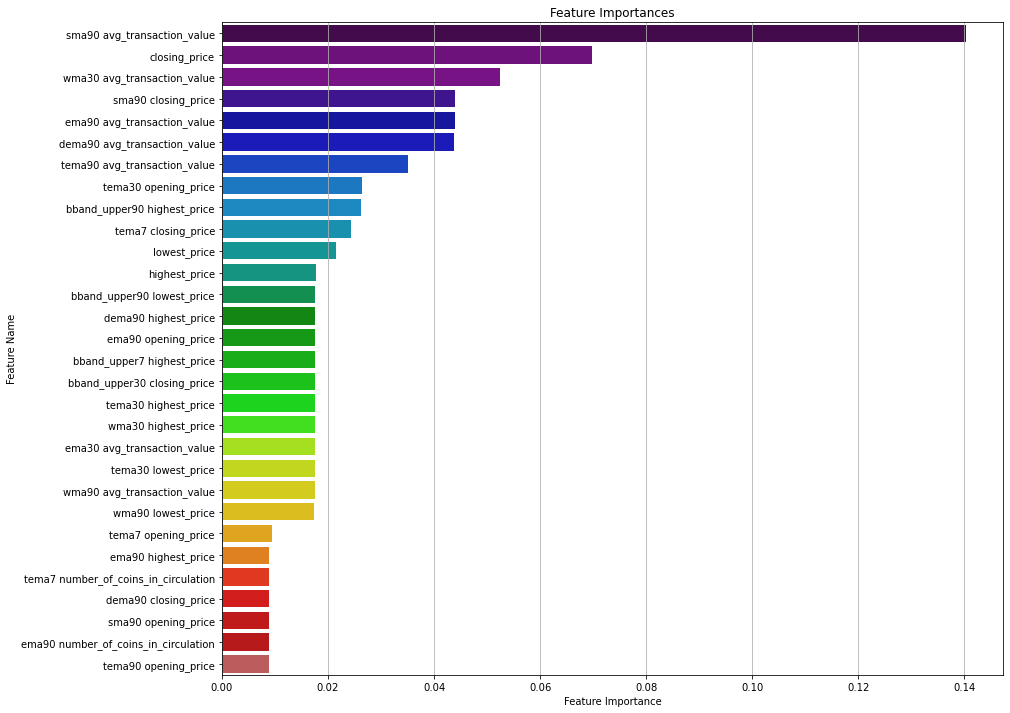

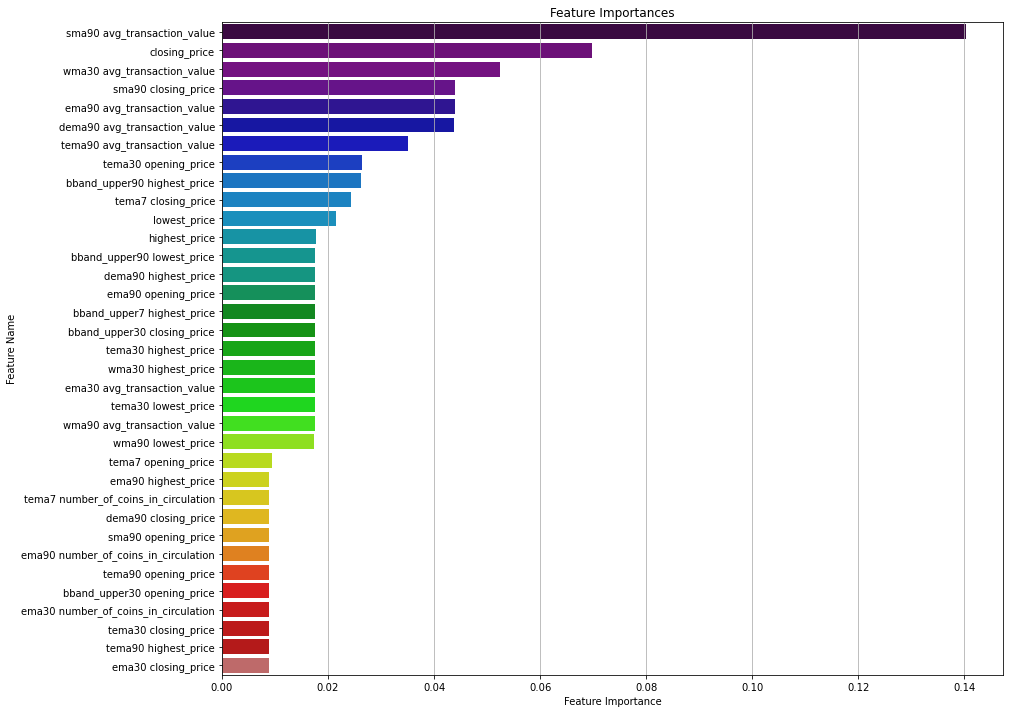

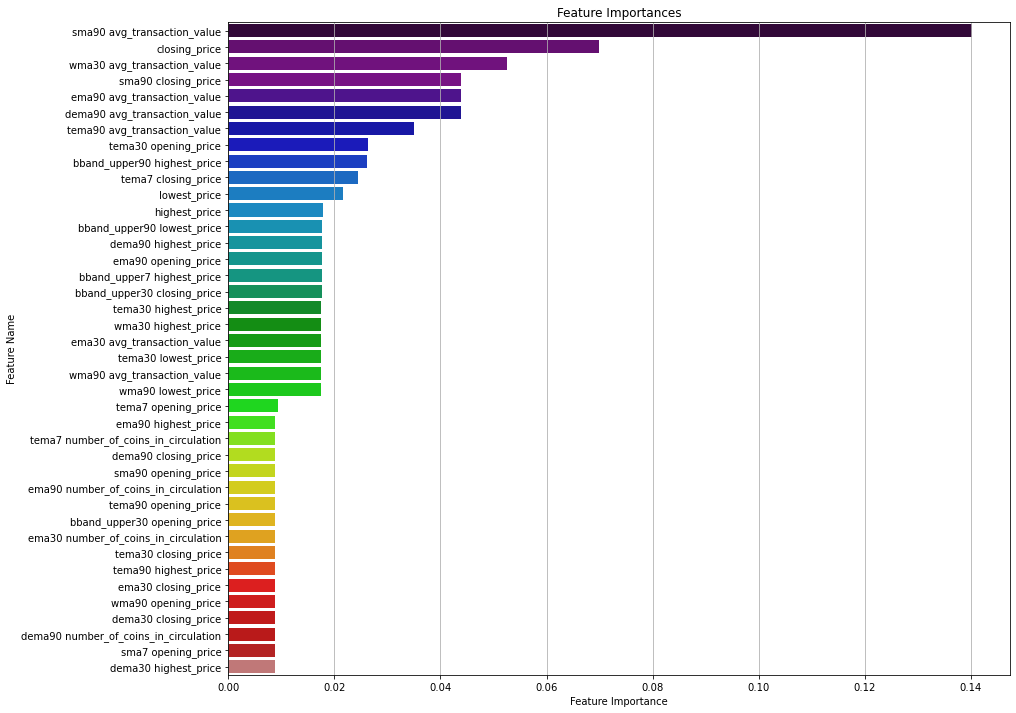

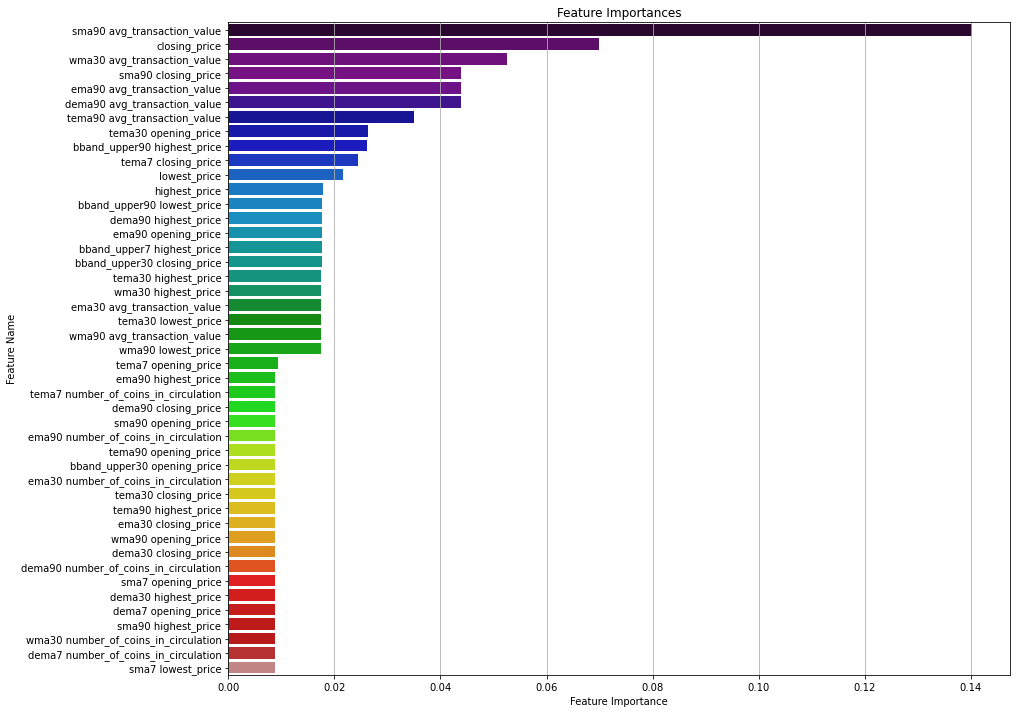

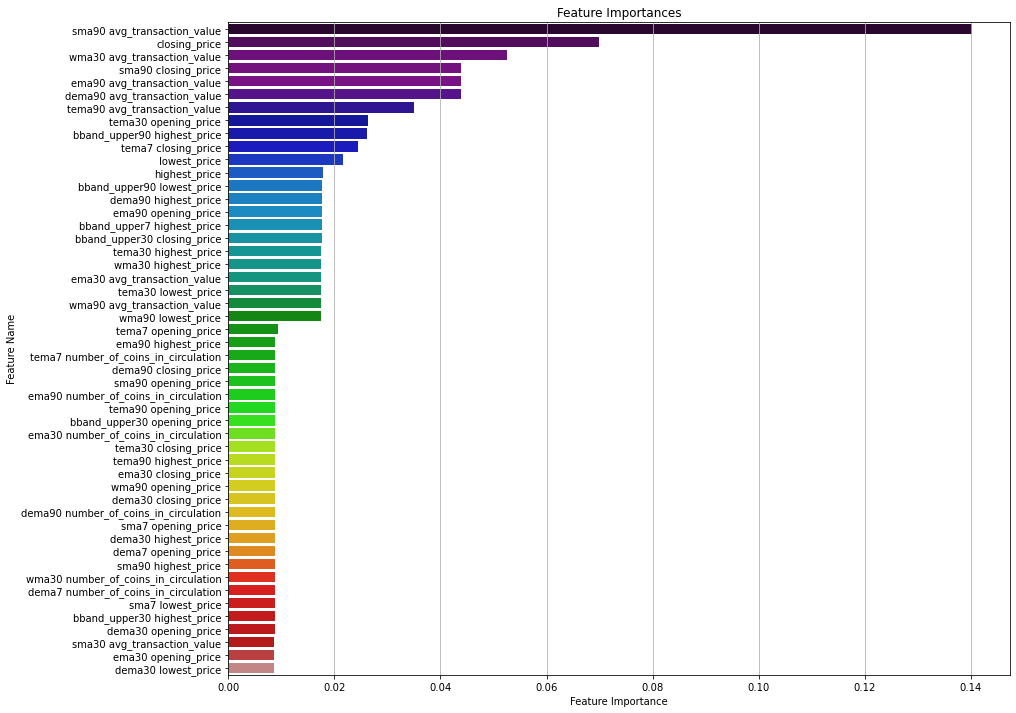

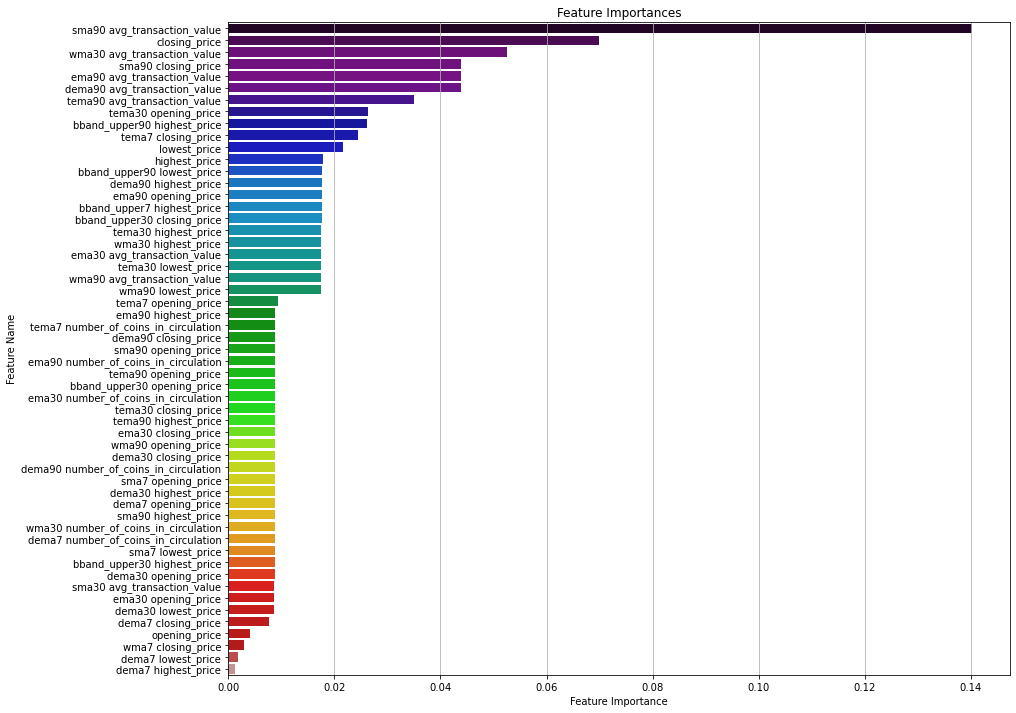

In [16]:
for i in feat_range:
    feat_imp_df,final_df_next_day = feature_imp(X_scaled,rf.feature_importances_,i)
    final_df_next_day.insert(loc=0, column='Date', value=final_df['Date'])
    final_df_next_day['next_day_closing_price'] = final_df['next_day_closing_price']
    feat_imp_df.to_csv('feature_imp.csv',index=False)
    final_df_next_day.to_csv('final_df_next_day.csv',index=False)

### Conclusion

The top 10 features that should be focused in the study are sma90 avg_transaction_value, closing price, wma30 avg_transaction_value, sma90 closing_price, ema90 avg_transaction_value, dema90 avg_transaction_value, tema90 avg_transaction_value, tema30 opening_price, bband_upper90 closing_price, tema7 closing_price.   

(Basically, the important features are average transaction value, closing price, opening price)

It is evident that most of the selected features were obtained after feature engineering. These features are decreasing the impurity to the level best. The following feature selection has been made easy using the visual plot which keeps showing the feature importance of all the variables in non-increasing order.